# Bathymetry effect

We found that the correlation between the cross-slope heat transport and the ASC speed is low through most of the 1000 m isobath. However, it is not quite clear why some reagions had a bigger correlation the others. To me, some of the high correlations seem to happen near troughs. I wanted to check if the presence of troughs and deep bathymetry explain the locations with high correlation.


This notebook aims to answer this question by checking if the high correlations are associated to locations of deep troughs

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/x77/wf4500/ASC_project/analysis_figs/'

In [2]:
client = Client(n_workers=48)


2025-02-28 09:02:16,329 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:40355'.
2025-02-28 09:02:16,365 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43631'.
2025-02-28 09:02:16,369 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:33229'.
2025-02-28 09:02:16,370 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:38021'.
2025-02-28 09:02:16,392 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:39893'.
2025-02-28 09:02:16,395 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:40227'.
2025-02-28 09:02:16,397 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:34081'.
2025-02-28 09:02:16,400 - distributed.scheduler - WARNING - Received heartbeat from unregistered 

Importing data

In [3]:
#Cross slope heat transport + ZC 
# Load CSHT field
CSHT_along_fine = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/'\
'Cross_slope_heat_transport/OM2_IAF/daily_rho/*').resample(time='1M').mean()

#importing u_along in thin bins
u_along_unbinned_fine = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_rho/OM2_IAF_XYgrid/*').resample(time='1M').mean()
u_along_unbinned_fine.u_along_contour.resample(time='1M').mean()

#10 degrees binned ASC data monthly
u_along_unbinned_10deg = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_10deg_bin.nc').U




INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engin

KeyboardInterrupt: 

In [4]:

CSHT_ZC_10deg = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc')



Let's now import the depth along the unbinned isobath. Please remenber that for this model the actual heat transport values are on the U grid

In [5]:
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

depth_model =  cc.querying.getvar(iaf_cycle3,'ht' , session,n=1).sel(yt_ocean=slice(-90,-40))

depth_model_u =  cc.querying.getvar(iaf_cycle3,'hu' , session,n=1).sel(yu_ocean=slice(-90,-40))

depth_model_u_contour = depth_model_u.copy()

#extracting depth along isobath
depth_model = depth_model.sel(xt_ocean = CSHT_along_fine.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean = CSHT_along_fine.lat_along_contour.isel(time=0).drop('time'), method = 'nearest').load()

depth_model_u = depth_model_u.sel(xu_ocean = CSHT_along_fine.lon_along_contour.isel(time=0).drop('time'),\
yu_ocean = CSHT_along_fine.lat_along_contour.isel(time=0).drop('time'), method = 'nearest').load()


In [24]:
#Binning the depth of the model in 10 degree bins
#and extracting the maximum and minimum values
lon_bin=10
bin_edges = np.arange(CSHT_along_fine.lon_bin_midpoints[0], CSHT_along_fine.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)


# For U grid
#maximum depth in the bin will be
depth_model_max = depth_model_u.groupby_bins('xu_ocean', bins=bin_edges).max()
#minimum depth in the bin will be
depth_model_min = depth_model_u.groupby_bins('xu_ocean', bins=bin_edges).min()
#delta depth in the bin will be
delta_depth_model =  (depth_model_max - depth_model_min)


# For T grid
#maximum depth in the bin will be
depth_model_Tmax = depth_model.groupby_bins('xt_ocean', bins=bin_edges).max()
#minimum depth in the bin will be
depth_model_Tmin = depth_model.groupby_bins('xt_ocean', bins=bin_edges).min()
#delta depth in the bin will be
delta_depth_Tmodel =  (depth_model_Tmax - depth_model_Tmin)


delta_depth_meangrid = delta_depth_model.copy()
delta_depth_meangrid_values =(delta_depth_Tmodel.values + delta_depth_model.values)/2
delta_depth_meangrid.values = delta_depth_meangrid_values


#trying through the standard deviation method
depth_model_std = depth_model_u.groupby_bins('xu_ocean', bins=bin_edges).std()


#lets try to define the troughs by deviding the range by the standard deviation
#the idea here is that if the range is much bigger than the standard deviation,
# then we are likely to have a deep trough in it. if it isnt, then probaly not
troughs_stats_std = (delta_depth_model/(depth_model_std))

#another way is to pick up the maximum depths, diminish the target isobath value
#of a 1000 m. Some bins are still gonna be on averge bigger than others, 
# so we will also remove the std here, to make sure we are only targeting
# the deep troughs

troughs_depth = (depth_model_max-1000)
troughs_depth = troughs_depth.where(troughs_depth>0)
troughs_depth = troughs_depth - (0.5*depth_model_std)
troughs_depth = troughs_depth.where(troughs_depth>0)


#trough identification as 1000m minus the maximum bathymetry
#trghough,by difference of maximum depth and 1000 m 
depth_trough_diff = depth_model_max - 1000
depth_trough_Tdiff = depth_model_Tmax - 1000
depth_trough_Tdiff = depth_trough_Tdiff.rename({'xt_ocean_bins':'xu_ocean_bins'})
depth_trough_Tdiff['xu_ocean_bins'] = depth_trough_diff.xu_ocean_bins
depth_trough_2gridsdiff = (depth_trough_diff + depth_trough_Tdiff)/2
depth_trough_diff_meandepth = depth_model_max - depth_model_u.groupby_bins('xu_ocean', bins=bin_edges).mean()
depth_trough_diff_Tmeandepth = depth_model_Tmax - depth_model.groupby_bins('xt_ocean', bins=bin_edges).mean()
depth_trough_diff_Tmeandepth = depth_trough_diff_Tmeandepth.rename({'xt_ocean_bins':'xu_ocean_bins'})
depth_trough_diff_Tmeandepth['xu_ocean_bins'] = depth_trough_diff.xu_ocean_bins
depth_trough_diff_meandepth_2gridsdiff = (depth_trough_diff_Tmeandepth + depth_trough_diff_meandepth)/2

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Enteri

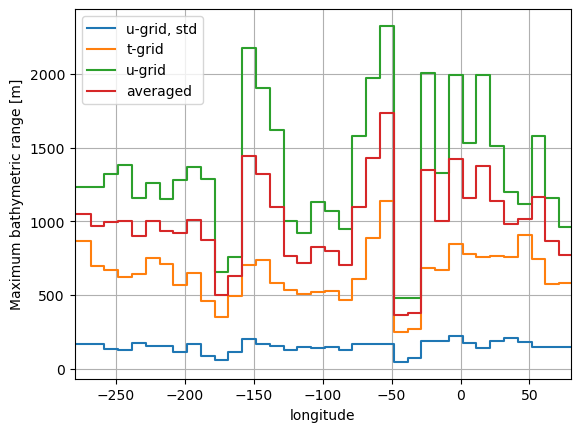

In [7]:
depth_model_std.plot.step(label = 'u-grid, std')
delta_depth_model.plot.step(label = 't-grid')
delta_depth_Tmodel.plot.step(label = 'u-grid')
delta_depth_meangrid.plot.step(label = 'averaged')
plt.ylabel('Maximum bathymetric range [m]')
plt.xlabel('longitude')
plt.xlim(-280,80)
plt.grid()
plt.legend()

Opening the correlations

In [8]:
files_path = '/g/data/e14/qo9901/ASC_collab_CSHT_ds/'

In [9]:
# 10deg
file_extension = 'agemaskCDW_volav'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_10degBins_' + file_extension + '.nc')
r_sq_all_10deg = ds.r_sq_all
ds.close()

# ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension + '.nc')
# r_sq_clima_10deg = ds.r_sq_clim
# ds.close()

ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + 'agemaskCDW_daily' + '.nc')
r_sq_clima_10deg = ds.r_sq_clim
ds.close()

'''
#changed
ds = xr.open_dataset(files_path + 'r_sq_daily_10degBins_' + file_extension + '.nc')
r_sq_clima_10deg = ds.r_sq_daily
ds.close()
#changed
'''

ds = xr.open_dataset(files_path + 'slope_annual_10degBins_' + file_extension + '.nc')
slope_sq_annual_10deg = ds.slope_annual
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_10degBins_' + file_extension + '.nc')
slope_sq_all_10deg = ds.slope_all
ds.close()

ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension + '.nc')
slope_sq_clima_10deg = ds.slope_clima
ds.close()




file_extension = 'agemaskCDW_volav'
file_extension_daily_clima = 'agemaskCDW_daily'
ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension_daily_clima + '_corr.nc')
r_sq_daily_10deg = ds.r_sq_clim
ds.close()
CSHT_lon_along_contour = CSHT_along_fine.lon_along_contour.isel(time=0)
CSHT_lat_along_contour = CSHT_along_fine.lat_along_contour.isel(time=0)
r_sq_daily_10deg_interp = r_sq_daily_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})


LEt's now do some dispersion plots between the correlations and depth

In [10]:
#realigning lon bins

r_sq_all_10deg['lon_bins'] = delta_depth_model['xu_ocean_bins'].values
r_sq_annual_10deg['lon_bins'] = delta_depth_model['xu_ocean_bins'].values
r_sq_clima_10deg['lon_bins'] = delta_depth_model['xu_ocean_bins'].values
r_sq_daily_10deg['lon_bins'] = delta_depth_model['xu_ocean_bins'].values

In [11]:
from matplotlib.patches import Polygon

In [12]:
def subplot_corr_along_contour(subplot_ax, quantity, type_quantity):
    ax_cric = subplot_ax#.add_axes([0,0,0.9,.9])

    if type_quantity == 'corr':
        scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = quantity, cmap = discrete_cmap(10, cmocean.dense), 
                               vmin = 0, vmax = 1)
    elif type_quantity == 'slope':
        scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = quantity, cmap =custom_cmap_slope, 
                       vmin = -120,vmax =120) # 150 for cric ##-300,300 for CDW, -90, 90 for AASW
        # for CDW daily climatology only below
        if subplot_ax == ax[1,1]:
            scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = quantity, cmap =custom_cmap_slope, 
                       vmin = -120,vmax =120)
                       
            
    ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='dimgrey', zorder=2)
    ax_cric.set_ylim([-80,-57])
    #ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
    #ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
    ax_cric.set_title(quantity.name,fontsize=fontsize)
    ax_cric.tick_params(labelsize=fontsize)
    ax_cric.set_facecolor('gainsboro') 

    '''
    axins1 = inset_axes(
        ax_cric,
        width="24%",  # width: 50% of parent_bbox width
        height="5%", # height: 5%
        loc='lower left',
        bbox_to_anchor = (0.735,0.04,1,1),
        bbox_transform=ax_cric.transAxes)
    cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
    
    
    if type_quantity == 'corr':
        cb.set_ticks([0,0.3,0.6,.9])
        cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
        
    elif type_quantity == 'slope':
        cb.set_label('Slope (TW/(m/s))',fontsize=fontsize)

    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_label_position("top")
    cb.ax.tick_params(labelsize=fontsize)
    '''    
    ax_cric.yaxis.set_major_formatter(LatitudeFormatter())
    ax_cric.xaxis.set_major_formatter(LongitudeFormatter())

    if (ax_cric == ax[2,0]) or (ax_cric == ax[2,1])  :
        cax = inset_axes(ax_cric,        
                        width="70%",  # width: 50% of parent_bbox width
                        height="5%", # height: 5%
                        loc='lower center',
                        bbox_to_anchor = (0,-0.19,1,1),
                        bbox_transform=ax_cric.transAxes)
        cb = fig.colorbar(scat, cax = cax, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
        cb.ax.tick_params(labelsize=fontsize)
        
        if type_quantity == 'corr':
            cb.set_ticks([0,0.3,0.6,.9])
            cb.set_label('Correlation [r$^2$]',fontsize=fontsize)
            
        elif type_quantity == 'slope':
            cb.set_label('Slope [TW/(m/s)]',fontsize=fontsize)
            
    return

In [13]:
# get things ready for plotting (land mask and colormap)

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# Data required for lat/lon mapping
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'
lat_slice = slice(-80, -59)
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [137]:
#getting the depth of CDW for making the fill plots
CDW_dense_zmean_halo = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/CDW_dense_zmean_halo.nc').st_edges_ocean[1:-1]

#we actually want the lighter surface
CDW_light_zmean_halo = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/CDW_light_zmean_halo.nc').st_edges_ocean[1:-1]
CDW_light_zmean_halo = CDW_light_zmean_halo.rename({'lon_bins':'xu_ocean_bins'})
CDW_light_zmean_halo['xu_ocean_bins'] = depth_model_max.xu_ocean_bins

In [152]:
#calculate the dzt between the trogh depth and the surface of CDW mean layer
CDW_thcikness_above_trough = (depth_model_max - CDW_light_zmean_halo)

# adding that thickness to the trough plot to make a visual plot of CDW thickness comapred to the trough depth

CDW_filling_trough =  depth_trough_diff_meandepth - CDW_thcikness_above_trough

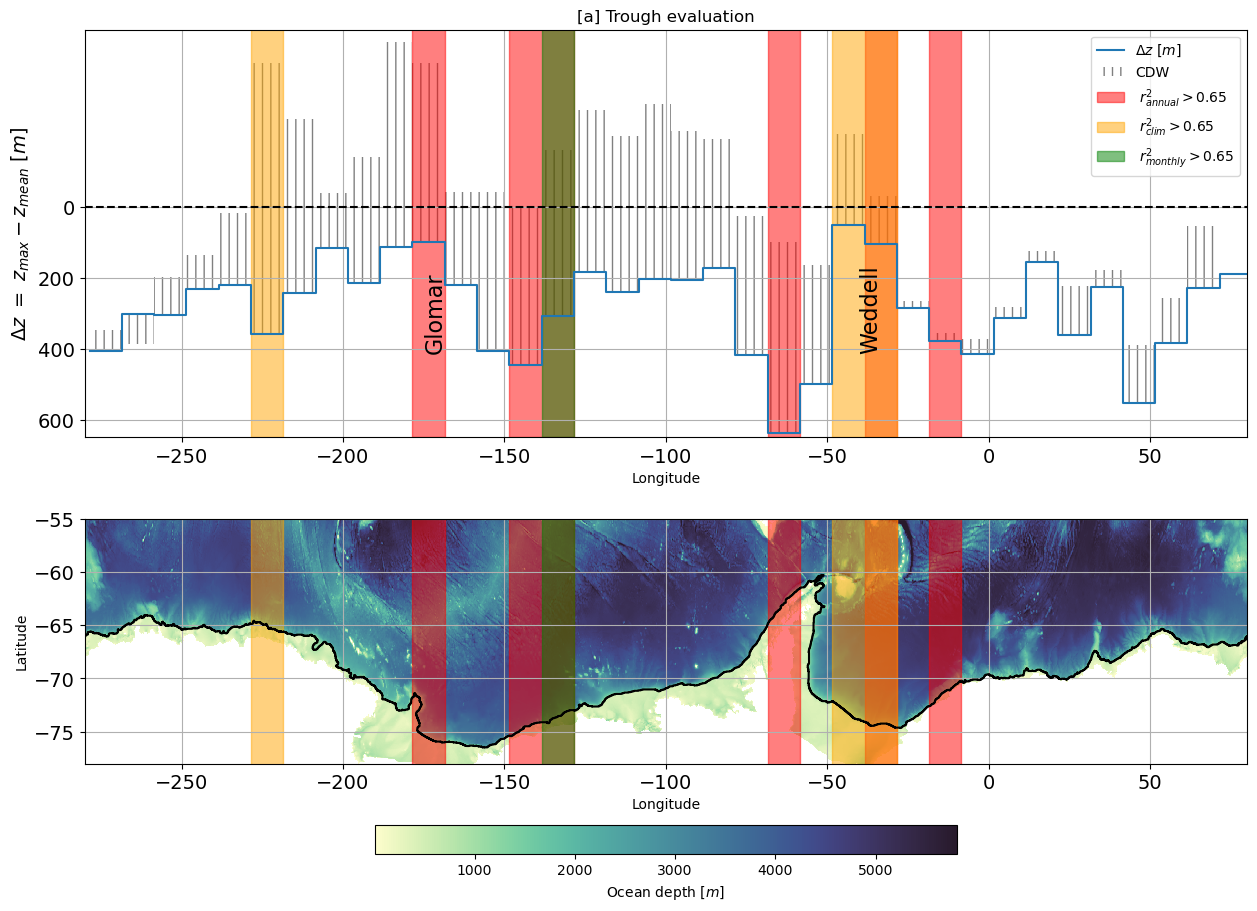

In [168]:
plt.figure(figsize = (15,18))
threshold = 0.65
alphalevel = 0.5

ax_311 = plt.subplot(3,1,1)
#(troughs_stats_std).plot.step(label = r'$\Delta z \ [km]$')
#delta_depth_model.plot.step(label = r'$\Delta z \ [m]$')
#depth_trough_2gridsdiff.plot.step(label = r'$\Delta z \ [m]$')
#depth_trough_diff.plot.step(label = r'$\Delta z \ [m]$')
#depth_trough_diff_meandepth_2gridsdiff.plot.step(label = r'$\Delta z \ [m]$')
depth_trough_diff_meandepth.plot.step(label = r'$\Delta z \ [m]$')

#CDW location
plt.fill_between(x = bin_edges[:-1], y1 = CDW_filling_trough, y2=  depth_trough_diff_meandepth\
                  ,step='post',hatch="||",color='grey',facecolor='none',linewidth=0,label='CDW')


#annual
#(r_sq_annual_10deg.where(r_sq_annual_10deg>threshold)).plot.step(label = 'annual correlation > ' + str(threshold) ,linewidth=8)
Bannual_Fill = ((r_sq_annual_10deg.where(r_sq_annual_10deg>threshold))*0 -600); Bannual_Fill =Bannual_Fill.fillna(-9999)
Tannual_Fill = ((r_sq_annual_10deg.where(r_sq_annual_10deg>threshold))*0 +650); Tannual_Fill =Tannual_Fill.fillna(-9999)
plt.fill_between(x = bin_edges[:-1], y1 = Bannual_Fill, y2=  Tannual_Fill, alpha = alphalevel,step = 'post', label=r' $r^2_{annual} > $' + str(threshold),color = 'red')

#daily
#(r_sq_daily_10deg.where(r_sq_daily_10deg>threshold)).plot.step(label = 'climatology correlation > '  + str(threshold),linewidth=5)
Bdaily_Fill = ((r_sq_daily_10deg.where(r_sq_daily_10deg>threshold))*0 -600); Bdaily_Fill =Bdaily_Fill.fillna(-9999)
Tdaily_Fill = ((r_sq_daily_10deg.where(r_sq_daily_10deg>threshold))*0 +650); Tdaily_Fill =Tdaily_Fill.fillna(-9999)
plt.fill_between(x = bin_edges[:-1], y1 = Bdaily_Fill, y2=  Tdaily_Fill, alpha = alphalevel,step = 'post', label=r' $r^2_{clim} > $' + str(threshold),color = 'orange')

#all
#(r_sq_all_10deg.where(r_sq_all_10deg>threshold)).plot.step(label = 'all correlation > '  + str(threshold),linewidth=2)
Ball_Fill = ((r_sq_all_10deg.where(r_sq_all_10deg>threshold))*0 -600); Ball_Fill =Ball_Fill.fillna(-9999)
Tall_Fill = ((r_sq_all_10deg.where(r_sq_all_10deg>threshold))*0 +650); Tall_Fill =Tall_Fill.fillna(-9999)
plt.fill_between(x = bin_edges[:-1], y1 = Ball_Fill, y2=  Tall_Fill, alpha =alphalevel,step = 'post', label=r' $r^2_{monthly} > $' + str(threshold),color = 'green')
plt.plot([-280,80],[0,0],color  = 'black',linestyle = '--')
plt.text(-175,400,'Glomar',rotation = 90,fontsize = 16)
plt.text(-40,400,'Weddell',rotation = 90,fontsize = 16)
plt.yticks(ticks=[0,200,400,600],fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Longitude')
plt.ylabel(r'$\Delta z \ = \ z_{max} - z_{mean}$ [$m$]',fontsize = 14)
plt.xlim(-280,80)
plt.grid()
plt.ylim(650,-500)
plt.legend()
plt.title('[a] Trough evaluation')



ax_map = plt.subplot(3,1,2)
Depth_map = depth_model_u_contour.plot.pcolormesh(cmap=cmocean.deep,add_colorbar = False)
plt.colorbar(Depth_map,location = 'bottom',fraction = 0.25,shrink=0.5,label= r'Ocean depth [$m$]')
plt.plot(CSHT_along_fine.lon_along_contour.isel(time=0),CSHT_along_fine.lat_along_contour.isel(time=0),color='black')
plt.fill_between(x = bin_edges[:-1], y1 = Bannual_Fill, y2=  Tannual_Fill, alpha = alphalevel,step = 'post', label=r' $r^2_{annual} > $' + str(threshold),color = 'red')
plt.fill_between(x = bin_edges[:-1], y1 = Bdaily_Fill, y2=  Tdaily_Fill, alpha =alphalevel,step = 'post', label=r' $r^2_{clim} > $' + str(threshold),color = 'orange')
plt.fill_between(x = bin_edges[:-1], y1 = Ball_Fill, y2=  Tall_Fill, alpha = alphalevel,step = 'post', label=r' $r^2_{monthly} > $' + str(threshold),color = 'green')
plt.ylim(-78,-55)
plt.xlim(-280,80)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.grid()

Interestingly, it seems like some of the high correlations are pretty well aligned with deeper bathymetry. It would be awesome if we could plot over here also the mean depth of CDW according to our definition!. 


So let's try

WHat about instead of depth, we plot in the bottom contour the temperature in the CDW layer?

In [12]:
#realigning lon bins

slope_sq_all_10deg['lon_bins'] = delta_depth_model['xu_ocean_bins'].values
slope_sq_annual_10deg['lon_bins'] = delta_depth_model['xu_ocean_bins'].values
slope_sq_clima_10deg['lon_bins'] = delta_depth_model['xu_ocean_bins'].values

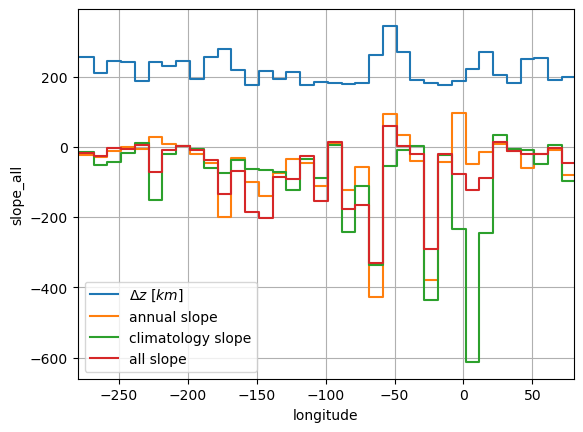

In [13]:

(troughs_stats_std*50).plot.step(label = r'$\Delta z \ [km]$')
(slope_sq_annual_10deg).plot.step(label = 'annual slope')
(slope_sq_clima_10deg).plot.step(label = 'climatology slope')
(slope_sq_all_10deg).plot.step(label = 'all slope')
plt.xlabel('longitude')
plt.xlim(-280,80)
plt.grid()
plt.legend()

I can see it mattering in some locations, but still, not that much! I guess it depends a lot on where CDW is located along the water column too, so it is not only about depth

It might be worth to do a plot where we can cotnrast the maximum depth along the contour with the depth of CDW. I imagine that the lowest the difference between the model trough depth and the mean CDW depth, the higher the correlation

What about a correlation with locations that have on average weak ASC in CDW layer?

In [14]:
#Importing masks 
CDW_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/CDW_age_mask.nc').CDW_mask.load()
DSW_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/DSW_age_mask.nc').DSW_mask.load()
AASW_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/AASW_age_mask.nc').AASW_mask.load()

In [15]:
vol_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Volume_rho_10deg_bins.nc').volume
vol_bins

<xarray.DataArray 'volume' (time: 732, potrho0: 108, lon_bins: 36)> Size: 23MB
dask.array<open_dataset-volume, shape=(732, 108, 36), dtype=float64, chunksize=(732, 108, 36), chunktype=numpy.ndarray>
Coordinates:
  * potrho0   (potrho0) float64 864B 21.5 23.07 23.22 ... 28.13 28.14 29.08
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * lon_bins  (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5

In [16]:
# 10deg
file_extension = 'agemaskCDW_volav'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_10degBins_' + file_extension + '.nc')
r_sq_all_10deg = ds.r_sq_all
ds.close()

ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension + '.nc')
r_sq_clima_10deg = ds.r_sq_clim
ds.close()
'''
ds = xr.open_dataset(files_path + 'r_sq_daily_10degBins_' + file_extension + '.nc')
r_sq_daily_10deg = ds.r_sq_daily
ds.close()
'''

ds = xr.open_dataset(files_path + 'slope_annual_10degBins_' + file_extension + '.nc')
slope_sq_annual_10deg = ds.slope_annual
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_10degBins_' + file_extension + '.nc')
slope_sq_all_10deg = ds.slope_all
ds.close()

ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension + '.nc')
slope_sq_clima_10deg = ds.slope_clima
ds.close()

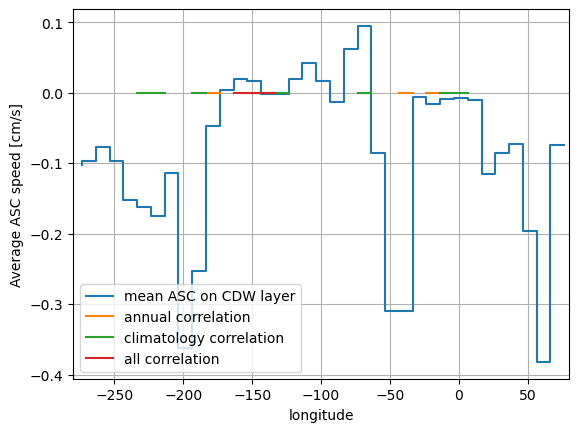

In [20]:
((u_along_unbinned_10deg*CDW_mask).mean(('time','potrho0'))*100).plot.step(label='mean ASC on CDW layer')
(r_sq_annual_10deg.where(r_sq_annual_10deg>0.6)*0).plot.step(label = 'annual correlation')
(r_sq_clima_10deg.where(r_sq_clima_10deg>0.6)*0).plot.step(label = 'climatology correlation')
(r_sq_all_10deg.where(r_sq_all_10deg>0.6)*0).plot.step(label = 'all correlation')

plt.ylabel('Average ASC speed [cm/s]')
plt.xlabel('longitude')
plt.xlim(-280,80)
plt.grid()
plt.legend()

ok, I see something here....